# Load dataset to train example model

Add [this Google folder](https://drive.google.com/drive/folders/1K54qqwYtk1ADJlkptJNF-FfyjQ7R6KGC?usp=sharing) to your drive then adjust the paths in the `current_directory` variable 

In [ ]:
import warnings
warnings.filterwarnings("ignore")

from google.colab import drive
import os
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
current_directory = "/content/drive/MyDrive/AI/Trained models"
os.chdir("/content/drive/MyDrive/AI/Trained models")

In [ ]:
import pandas as pd

In [ ]:
df = pd.read_csv("Perplexity.csv", encoding="latin1")
df.dropna(inplace=True)
df['Mean Perplexity'] = df['Mean Perplexity'].astype(float)
print(len(df))
df.head(1)

15979


,question,Raw_Text,Text,Label,Mean Perplexity
0,What are squatter 's rights in California and ...,Adverse possession far predates the formation ...,adverse possession far predates formation u ho...,0,98.381706


In [ ]:
print(max(df["Mean Perplexity"]))
print(min(df["Mean Perplexity"]))

24966.77449
8.212570071


Conduct normalisation on numeric column -- mean perplexity

In [ ]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np
#Normalize perplexity features -- MinMax scaling
df["Mean Perplexity"] = MinMaxScaler().fit_transform(np.array(df["Mean Perplexity"]).reshape(-1,1))  
df.head(1)

,question,Raw_Text,Text,Label,Mean Perplexity
0,What are squatter 's rights in California and ...,Adverse possession far predates the formation ...,adverse possession far predates formation u ho...,0,0.003613


In [ ]:
df.dtypes

question            object
Raw_Text            object
Text                object
Label                int64
Mean Perplexity    float64
dtype: object

Ensure that there is no skew in the dataset

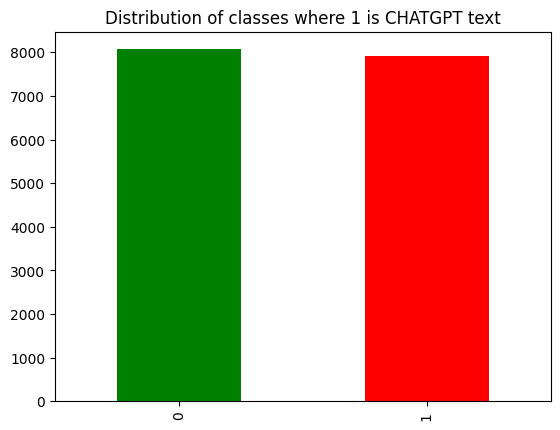

In [ ]:
import matplotlib.pyplot as plt

count_Class=pd.value_counts(df["Label"], sort= True)
count_Class.plot(kind = 'bar',color = ["green","red"])
plt.title('Distribution of classes where 1 is CHATGPT text')
plt.show()

# Experiment: Text + Perplexity Column with Keras LSTM

Accuracy: 73%

In [ ]:
!pip install tensorflow_text

In [ ]:
import tensorflow as tf
import numpy as np
import tensorflow_hub as hub
import tensorflow_text as text
from sklearn.model_selection import train_test_split

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

Define the model layers
- We are using BERT embeddings as text input
- We are also taking in a numeric column so we will concatenate two neural networks to get the final prediction

In [ ]:
# Define the BERT model
BERT_MODEL = "https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1" 
# Choose the preprocessing that must match the model
PREPROCESS_MODEL = "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3"

preprocess = hub.load(PREPROCESS_MODEL)
bert = hub.load(BERT_MODEL)

# create model -- numeric features in this e.g. are mean perplexity
numeric_col_count = 1
numeric_input_layer = tf.keras.layers.Input(shape=(numeric_col_count,))
numeric_dense_layer_4 = tf.keras.layers.Dense(64, activation='relu')(numeric_input_layer)

# second input model
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
preprocessing_layer = hub.KerasLayer(PREPROCESS_MODEL, name='preprocessing')
encoder_inputs = preprocessing_layer(text_input)
encoder = hub.KerasLayer(BERT_MODEL, trainable=True, name='BERT_encoder')
outputs = encoder(encoder_inputs)
net = outputs['sequence_output']
net = tf.keras.layers.Dropout(0.1)(net)
net = tf.keras.layers.Dense(1, activation=None, name='classifier')(net)
lstm = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True))(net)
lstm = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32))(net)
lstm_dense = tf.keras.layers.Dense(64, activation='relu')(lstm)

# merge input models
merge = tf.keras.layers.concatenate([lstm_dense, numeric_dense_layer_4])

# interpretation model
hidden1 = tf.keras.layers.Dense(32, activation='relu')(merge)
hidden2 = tf.keras.layers.Dense(10, activation='relu')(hidden1)
output = tf.keras.layers.Dense(1, activation='sigmoid')(hidden2)
rnn_model = tf.keras.models.Model(inputs=[numeric_input_layer, text_input], outputs=output)

rnn_model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy', tf.keras.metrics.FalsePositives()])

Train the model
- Early stopping included to prevent overfitting

In [ ]:
# split into input (X) and output (Y) variables]
X = df[["Mean Perplexity","Raw_Text"]]
y = df['Label'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=1)
history = rnn_model.fit([np.asarray(X_train["Mean Perplexity"].values).astype('float32'), X_train["Raw_Text"].values], y_train, epochs=5, verbose=True, validation_split=0.1, batch_size=32)

Epoch 1/5
315/315 [==============================] - 149s 357ms/step - loss: 0.6936 - accuracy: 0.5058 - false_positives: 2283.0000 - val_loss: 0.6937 - val_accuracy: 0.5040 - val_false_positives: 2.0000
Epoch 2/5
315/315 [==============================] - 99s 314ms/step - loss: 0.6927 - accuracy: 0.5114 - false_positives: 1124.0000 - val_loss: 0.6915 - val_accuracy: 0.5040 - val_false_positives: 2.0000
Epoch 3/5
315/315 [==============================] - 91s 290ms/step - loss: 0.6909 - accuracy: 0.5210 - false_positives: 962.0000 - val_loss: 0.6874 - val_accuracy: 0.5058 - val_false_positives: 0.0000e+00
Epoch 4/5
315/315 [==============================] - 96s 304ms/step - loss: 0.6792 - accuracy: 0.5872 - false_positives: 1343.0000 - val_loss: 0.6543 - val_accuracy: 0.6256 - val_false_positives: 418.0000
Epoch 5/5
315/315 [==============================] - 87s 277ms/step - loss: 0.5939 - accuracy: 0.7579 - false_positives: 1672.0000 - val_loss: 0.5106 - val_accuracy: 0.7453 - val_fal

Evaluate the model
- Model tends to predict human as AI more (false positive) as compared to AI as human (false negative)

In [ ]:
rnn_model.evaluate([X_test["Mean Perplexity"], X_test['Raw_Text']], y_test, verbose=False)

[0.5210092067718506, 0.736754298210144, 1186.0]

150/150 [==============================] - 21s 132ms/step


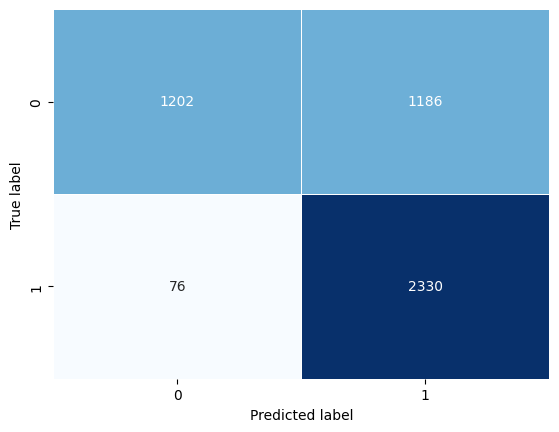

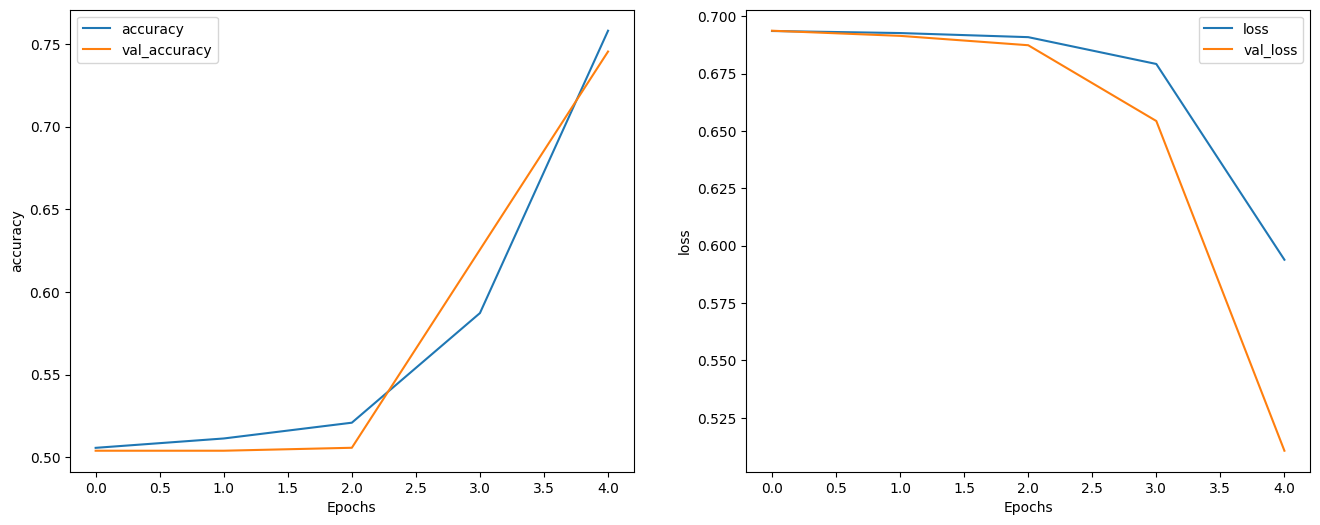

In [ ]:
def plot_confusion_matrix(y_true, y_pred):
   mtx = confusion_matrix(y_true, y_pred)
   sns.heatmap(mtx, annot=True, fmt='d', linewidths=.5, 
               cmap="Blues", cbar=False)
   plt.ylabel('True label')
   plt.xlabel('Predicted label')


def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

cont_preds = rnn_model.predict([X_test["Mean Perplexity"], X_test['Raw_Text']])
preds = (cont_preds > 0.5).astype("int32")
plot_confusion_matrix(y_test, preds)

plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')

In [ ]:
#save model
current_directory = os.getcwd()
rnn_model.save(current_directory+"/rnn_features_model")

# Experiment: Text + Perplexity Column -- AutoKeras

To find ways to improve the accuracy, I experimented with AutoKeras to try different neural networks. 

The best model after 15 models was a Convolutional Neural Network with accuracy: 0.9470 - auc: 0.9742

In [ ]:
!pip install git+https://github.com/keras-team/keras-tuner.git
!pip install autokeras

In [ ]:
import autokeras as ak

Prepare data

In [ ]:
from sklearn.model_selection import train_test_split
X = df[["Raw_Text","Mean Perplexity"]]
y = df['Label'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

Prepare neural network structure to take in text and numeric input, concatenate the two neural networks from the different layers and produce a regression output

In [ ]:
#For diversity in ensemble models, transformers and ngrams will not be used in the text block
#Pretrained embeddings e.g. glove, word2vec or fasttext is automatically tuned 
input_node_structured = ak.StructuredDataInput()
output_node_structured = ak.DenseBlock()(input_node_structured)

input_node_text = ak.TextInput()
output_node_text = ak.TextBlock(block_type='vanilla')(input_node_text)

output_node_merged = ak.Merge()([output_node_structured, output_node_text])
final_node = ak.RegressionHead(metrics=["accuracy","AUC"])(output_node_merged)

reg = ak.AutoModel(
   inputs=[input_node_structured, input_node_text],
   outputs=[final_node],
   max_trials=10,
)
reg.fit([X_train[["Mean Perplexity"]],X_train["Raw_Text"].to_numpy()], y_train, validation_split=0.15)

Trial 26 Complete [00h 02m 06s]
val_loss: 0.033185090869665146

Best val_loss So Far: 0.030185863375663757
Total elapsed time: 00h 02m 07s
Epoch 1/10
350/350 [==============================] - 16s 38ms/step - loss: 0.0960 - accuracy: 0.8737 - auc: 0.9470
Epoch 2/10
350/350 [==============================] - 4s 12ms/step - loss: 0.0433 - accuracy: 0.9477 - auc: 0.9859
Epoch 3/10
350/350 [==============================] - 3s 8ms/step - loss: 0.0327 - accuracy: 0.9622 - auc: 0.9901
Epoch 4/10
350/350 [==============================] - 3s 9ms/step - loss: 0.0255 - accuracy: 0.9711 - auc: 0.9930
Epoch 5/10
350/350 [==============================] - 3s 8ms/step - loss: 0.0202 - accuracy: 0.9780 - auc: 0.9949
Epoch 6/10
350/350 [==============================] - 4s 11ms/step - loss: 0.0177 - accuracy: 0.9820 - auc: 0.9960
Epoch 7/10
350/350 [==============================] - 3s 10ms/step - loss: 0.0150 - accuracy: 0.9846 - auc: 0.9965
Epoch 8/10
350/350 [==============================] - 3s 9

Evaluate the model

In [ ]:
# Predict with the best model.
predicted_y = reg.predict([X_test[["Mean Perplexity"]],X_test["Raw_Text"].to_numpy()])
# Evaluate the best model with testing data.
print(reg.evaluate([X_test[["Mean Perplexity"]],X_test["Raw_Text"].to_numpy()], y_test))

150/150 [==============================] - 1s 5ms/step - loss: 0.0454 - accuracy: 0.9470 - auc: 0.9742
[0.045413970947265625, 0.9470171332359314, 0.9741848111152649]


Export model

In [ ]:
# Export as a Keras Model.
model = reg.export_model()
model.summary()
try:
    model.save("model_autokeras_vanilla", save_format="tf")
except Exception:
    model.save("model_autokeras_vanilla.h5")

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None,)]            0           []                               
                                                                                                  
 expand_last_dim (ExpandLastDim  (None, 1)           0           ['input_2[0][0]']                
 )                                                                                                
                                                                                                  
 text_vectorization (TextVector  (None, 64)          0           ['expand_last_dim[0][0]']        
 ization)                                                                                         
                                                                                              

Load model to check if it works 

In [ ]:
import tensorflow as tf
loaded_model = tf.keras.models.load_model("model_autokeras_vanilla", custom_objects=ak.CUSTOM_OBJECTS)
predicted_y = loaded_model.predict([X_test[["Mean Perplexity"]],X_test["Raw_Text"].to_numpy()])
print(predicted_y)

150/150 [==============================] - 1s 4ms/step
[[0.03908968]
 [1.0395148 ]
 [0.03272429]
 ...
 [0.04774358]
 [0.00254725]
 [0.01590082]]


# Experiment: Text -- AutoKeras

The best model after trying 5 models was a Convolutional Neural Network with 
accuracy: 0.9821 - auc: 0.9925

Less models were tried because each trial took a lot of memory and time

In [ ]:
!pip install git+https://github.com/keras-team/keras-tuner.git
!pip install autokeras

In [ ]:
import autokeras as ak

This dataset has more datapoints than the perplexity one. Perplexity takes a long time to scrape so we trained on as much data point as we could scrape.

In [ ]:
import pandas as pd
df = pd.read_csv("eli5_clean_combined.csv")
df.dropna(inplace = True)
df.head(1)

,response,Label
0,"Basically there are many categories of "" Best ...",0


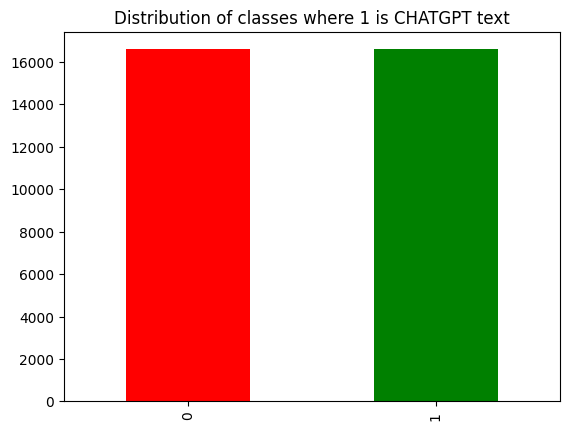

In [ ]:
import matplotlib.pyplot as plt
count_Class=pd.value_counts(df["Label"], sort= True)
count_Class.plot(kind = 'bar',color = ["green","red"])
plt.title('Distribution of classes where 1 is CHATGPT text')
plt.show()

In [ ]:
from sklearn.model_selection import train_test_split
X = df[["response"]]
y = df['Label'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

Train model

In [ ]:
reg = ak.TextRegressor(overwrite=True, max_trials=5, metrics=["accuracy","AUC"])
reg.fit(X_train["response"].to_numpy(), y_train, validation_split=0.15)

Trial 5 Complete [00h 04m 41s]
val_loss: 0.014697384089231491

Best val_loss So Far: 0.012621596455574036
Total elapsed time: 00h 28m 21s
Epoch 1/17
726/726 [==============================] - 49s 62ms/step - loss: 0.0961 - accuracy: 0.8896 - auc: 0.9510
Epoch 2/17
726/726 [==============================] - 9s 12ms/step - loss: 0.0244 - accuracy: 0.9738 - auc: 0.9937
Epoch 3/17
726/726 [==============================] - 7s 10ms/step - loss: 0.0127 - accuracy: 0.9885 - auc: 0.9974
Epoch 4/17
726/726 [==============================] - 8s 10ms/step - loss: 0.0087 - accuracy: 0.9926 - auc: 0.9987
Epoch 5/17
726/726 [==============================] - 9s 12ms/step - loss: 0.0064 - accuracy: 0.9948 - auc: 0.9993
Epoch 6/17
726/726 [==============================] - 9s 12ms/step - loss: 0.0048 - accuracy: 0.9964 - auc: 0.9996
Epoch 7/17
726/726 [==============================] - 8s 11ms/step - loss: 0.0048 - accuracy: 0.9961 - auc: 0.9994
Epoch 8/17
726/726 [==============================] - 9s

Evaluate Model

In [ ]:
# Predict with the best model.
predicted_y = reg.predict(X_test["response"].to_numpy())
# Evaluate the best model with testing data.
print(reg.evaluate(X_test["response"].to_numpy(), y_test))

311/311 [==============================] - 3s 8ms/step - loss: 0.0153 - accuracy: 0.9821 - auc: 0.9925
[0.015286284498870373, 0.9821123480796814, 0.9925251603126526]


Output model

In [ ]:
# Export as a Keras Model.
model = reg.export_model()
model.summary()
try:
    model.save("model_autokeras_vanilla_text_only", save_format="tf")
except Exception:
    model.save("model_autokeras_vanilla_text_only")

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None,)]                 0         
                                                                 
 expand_last_dim (ExpandLast  (None, 1)                0         
 Dim)                                                            
                                                                 
 text_vectorization (TextVec  (None, 128)              0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 128, 128)          640128    
                                                                 
 dropout (Dropout)           (None, 128, 128)          0         
                                                                 
 conv1d (Conv1D)             (None, 126, 32)           12320 

Load Model to check if it can predict

In [ ]:
import tensorflow as tf
loaded_model = tf.keras.models.load_model("model_autokeras_vanilla_text_only", custom_objects=ak.CUSTOM_OBJECTS)
predicted_y = loaded_model.predict(X_test["response"].to_numpy())
print(predicted_y)

311/311 [==============================] - 2s 7ms/step
[[-2.08175331e-02]
 [-1.38656795e-02]
 [-2.81576067e-03]
 ...
 [-2.06542313e-02]
 [ 9.78062987e-01]
 [-8.97668302e-04]]


# Experiment: Text + GLTR Feature -- AutoKeras

The best model after trying 3 models was a Convolutional Neural Network with accuracy: 0.9704 - auc: 0.9986

In [ ]:
!pip install git+https://github.com/keras-team/keras-tuner.git
!pip install autokeras

In [ ]:
import autokeras as ak

In [ ]:
import pandas as pd
df = pd.read_csv("scraped_gltr_features.csv")[["question","response","label","GLTR Category 1","GLTR Category 3"]]
df.dropna(inplace = True)
df.head(1)

,question,response,label,GLTR Category 1,GLTR Category 3
0,"Why is every book I hear about a "" NY Times # ...",There are many different best seller lists tha...,1.0,0.888412,0.017167


In [ ]:
gpt_df = df[df["label"] == 1]
human_df = df[df["label"] == 0][:len(gpt_df)]
processed_df = pd.concat([gpt_df, human_df])

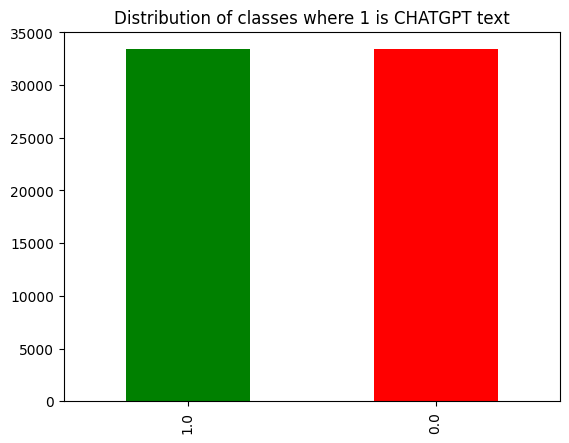

In [ ]:
import matplotlib.pyplot as plt
count_Class=pd.value_counts(processed_df["label"], sort= True)
count_Class.plot(kind = 'bar',color = ["green","red"])
plt.title('Distribution of classes where 1 is CHATGPT text')
plt.show()

In [ ]:
from sklearn.model_selection import train_test_split
X = processed_df[["response","GLTR Category 1","GLTR Category 3"]]
y = processed_df['label'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

In [ ]:
input_node_structured = ak.StructuredDataInput()
output_node_structured = ak.DenseBlock()(input_node_structured)

input_node_text = ak.TextInput()
output_node_text = ak.TextBlock(block_type='vanilla')(input_node_text)

output_node_merged = ak.Merge()([output_node_structured, output_node_text])
final_node = ak.RegressionHead(metrics=["accuracy","AUC"])(output_node_merged)

reg = ak.AutoModel(overwrite=True,
   inputs=[input_node_structured, input_node_text],
   outputs=[final_node],
   max_trials=3,
)
reg.fit([X_train[["GLTR Category 1","GLTR Category 3"]],X_train["response"].to_numpy()], y_train, validation_split=0.15)

Trial 3 Complete [00h 15m 56s]
val_loss: 0.012001670897006989

Best val_loss So Far: 0.011574359610676765
Total elapsed time: 00h 58m 58s
Epoch 1/16
1462/1462 [==============================] - 51s 33ms/step - loss: 0.0285 - accuracy: 0.9722 - auc: 0.9931
Epoch 2/16
1462/1462 [==============================] - 48s 33ms/step - loss: 0.0150 - accuracy: 0.9865 - auc: 0.9992
Epoch 3/16
1462/1462 [==============================] - 48s 33ms/step - loss: 0.0107 - accuracy: 0.9941 - auc: 0.9998
Epoch 4/16
1462/1462 [==============================] - 47s 32ms/step - loss: 0.0082 - accuracy: 0.9967 - auc: 0.9998
Epoch 5/16
1462/1462 [==============================] - 48s 32ms/step - loss: 0.0067 - accuracy: 0.9950 - auc: 0.9999
Epoch 6/16
1462/1462 [==============================] - 46s 32ms/step - loss: 0.0056 - accuracy: 0.9948 - auc: 0.9999
Epoch 7/16
1462/1462 [==============================] - 47s 32ms/step - loss: 0.0049 - accuracy: 0.9951 - auc: 0.9999
Epoch 8/16
1462/1462 [==============

In [ ]:
# Predict with the best model.
predicted_y = reg.predict([X_test[["GLTR Category 1","GLTR Category 3"]],X_test["response"].to_numpy()])
# Evaluate the best model with testing data.
print(reg.evaluate([X_test[["GLTR Category 1","GLTR Category 3"]],X_test["response"].to_numpy()], y_test))

627/627 [==============================] - 5s 7ms/step - loss: 0.0206 - accuracy: 0.9704 - auc: 0.9986
[0.020609285682439804, 0.9704091548919678, 0.9985998868942261]


In [ ]:
# Export as a Keras Model.
model = reg.export_model()
model.summary()
try:
    model.save("model_autokeras_gltr", save_format="tf")
except Exception:
    model.save("model_autokeras_gltr")

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None,)]            0           []                               
                                                                                                  
 expand_last_dim (ExpandLastDim  (None, 1)           0           ['input_2[0][0]']                
 )                                                                                                
                                                                                                  
 text_vectorization (TextVector  (None, 64)          0           ['expand_last_dim[0][0]']        
 ization)                                                                                         
                                                                                              

In [ ]:
import tensorflow as tf
loaded_model = tf.keras.models.load_model("model_autokeras_gltr", custom_objects=ak.CUSTOM_OBJECTS)
predicted_y = loaded_model.predict([X_test[["GLTR Category 1","GLTR Category 3"]],X_test["response"].to_numpy()])
print(predicted_y)

627/627 [==============================] - 5s 7ms/step
[[ 0.9761481 ]
 [ 0.9706696 ]
 [ 0.98814714]
 ...
 [ 0.968687  ]
 [-0.00653578]
 [ 0.00206957]]


# Holdout Dataset Evaluation of Models

First, the models will be wrapped in a Custom Class so that they can be added into an ensemble later

In [ ]:
#For RNN Feature Classifier
!pip install tensorflow_text
!pip install git+https://github.com/keras-team/keras-tuner.git
!pip install autokeras

In [ ]:
"""
For RNN Feature Classifier
!pip install tensorflow_text
"""
import autokeras as ak

from sklearn.base import BaseEstimator, ClassifierMixin, TransformerMixin
from sklearn.pipeline import Pipeline
from tensorflow.keras.models import load_model

import tensorflow as tf
import numpy as np
import tensorflow_hub as hub
import tensorflow_text as text
from tensorflow.keras.models import load_model

def flatten(l):
    return [item for sublist in l for item in sublist]

def process_output(preds):
  flattened_pred = flatten(preds)
  output = tf.constant(flattened_pred)
  return tf.math.sigmoid(output).numpy().tolist()

class RNNPerplexityClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, path):
      self.model=load_model(path)
    
    def predict(self, X, y=None):
      processed_X = self.process(X)
      return process_output(self.model.predict(processed_X))
    
    #Add any custom transformers as needed to produce the X input format your model needs 
    def process(self, X, y=None):
      output = [X[["Mean Perplexity"]].values, X["response"].values]
      return output

class CNNPerplexityClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, path):
      self.model=load_model(path,custom_objects=ak.CUSTOM_OBJECTS)
    
    def predict(self, X, y=None):
      processed_X = self.process(X)
      return process_output(self.model.predict(processed_X))

    #Add any custom transformers as needed to produce the X input format your model needs 
    def process(self, X, y=None):
      output = [X[["Mean Perplexity"]],X["response"].to_numpy()]
      return output

class CNNGLTRClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, path):
      self.model=load_model(path,custom_objects=ak.CUSTOM_OBJECTS)
    
    def predict(self, X, y=None):
      processed_X = self.process(X)
      return process_output(self.model.predict(processed_X))
    
    #Add any custom transformers as needed to produce the X input format your model needs 
    def process(self, X, y=None):
      output = [X[["GLTR Category 1","GLTR Category 3"]],X["response"].to_numpy()]
      return output

class CNNTextClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, path):
      self.model=load_model(path,custom_objects=ak.CUSTOM_OBJECTS)
    
    def predict(self, X, y=None):
      processed_X = self.process(X)
      return process_output(self.model.predict(processed_X))
    
    #Add any custom transformers as needed to produce the X input format your model needs 
    def process(self, X, y=None):
      output = X["response"].to_numpy()
      return output

In [ ]:
rnn_perplexity_classifier = RNNPerplexityClassifier(current_directory+"/rnn_features_model")
cnn_perplexity_classifier = CNNPerplexityClassifier(current_directory+"/model_autokeras_vanilla")
cnn_gltr_classifier = CNNGLTRClassifier(current_directory+"/model_autokeras_gltr")
cnn_text_classifier = CNNTextClassifier(current_directory+"/model_autokeras_vanilla_text_only")

Load holdout data and Normalise the columns


*   GLTR, Subjectivity is from 0 to 1



In [ ]:
from sklearn.preprocessing import MinMaxScaler
df = pd.read_csv("holdout_with_features.csv")
col_to_normalise = ["Mean Perplexity", "sum_mistakes", "Formality Score"]
for column in col_to_normalise:
  df[column] = MinMaxScaler().fit_transform(np.array(df[column]).reshape(-1,1))  
df.dropna(inplace=True)
df.head(1)

,response,Label,GLTR Category 1,GLTR Category 3,Mean Perplexity,sum_mistakes,TextBlob_Subjectivity,Formality Score
0,Hyperinflation comes almost always because of ...,0,0.605442,0.112245,0.034284,0.058824,0.417597,0.671505


In [ ]:
X = df.drop("Label",axis=1)
y = df['Label'].values

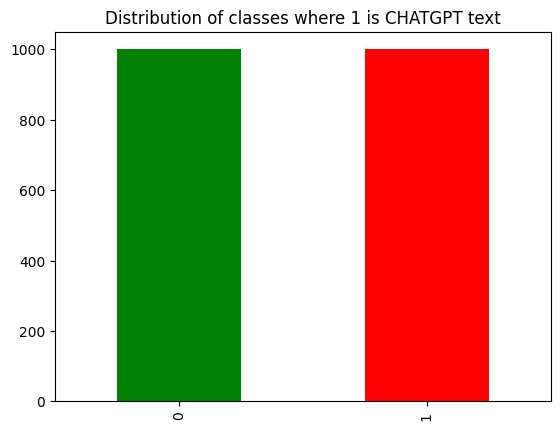

In [ ]:
import matplotlib.pyplot as plt
count_Class=pd.value_counts(df["Label"], sort= True)
count_Class.plot(kind = 'bar',color = ["green","red"])
plt.title('Distribution of classes where 1 is CHATGPT text')
plt.show()

Get Predictions

In [ ]:
from sklearn.metrics import classification_report,accuracy_score,f1_score,roc_auc_score  

def evaluate(pred, y_true, threshold):
  y_pred = np.array(pred)
  discrete = (y_pred > threshold).astype("int32")
  print(f"Accuracy: {accuracy_score(discrete, y)}")
  print(f"F1: {f1_score(discrete, y)}")
  print(f"ROC_AUC: {roc_auc_score(discrete, y)}")
  print(classification_report(discrete, y, target_names=["Human", "ChatGPT"]))

In [ ]:
rnn_prediction_output = rnn_perplexity_classifier.predict(X)
print(rnn_prediction_output)

63/63 [==============================] - 11s 170ms/step
[0.5169256329536438, 0.5254573822021484, 0.535881519317627, 0.5401878952980042, 0.5086976289749146, 0.5287972092628479, 0.5290522575378418, 0.5256655216217041, 0.5699979066848755, 0.529885470867157, 0.568962574005127, 0.5556480288505554, 0.5139241218566895, 0.5107952952384949, 0.5535072684288025, 0.5682755708694458, 0.5211166739463806, 0.5959980487823486, 0.6063179969787598, 0.5091206431388855, 0.521449625492096, 0.5610183477401733, 0.5121335387229919, 0.5304682850837708, 0.5319789052009583, 0.5812480449676514, 0.5395081043243408, 0.5973379611968994, 0.5938888788223267, 0.5123946666717529, 0.5349463224411011, 0.5099271535873413, 0.5250102281570435, 0.5115611553192139, 0.5218809843063354, 0.5176143050193787, 0.5198603272438049, 0.5624189972877502, 0.5519843697547913, 0.5434877276420593, 0.5269399285316467, 0.5428221821784973, 0.5580783486366272, 0.5271944999694824, 0.5187992453575134, 0.5223661661148071, 0.5103232264518738, 0.52715

In [ ]:
print("RNN Perplexity Classifier")
evaluate(rnn_prediction_output, y, 0.6)

RNN Perplexity Classifier
Accuracy: 0.964
F1: 0.9642857142857142
ROC_AUC: 0.9641188144164906
              precision    recall  f1-score   support

       Human       0.96      0.97      0.96       984
     ChatGPT       0.97      0.96      0.96      1016

    accuracy                           0.96      2000
   macro avg       0.96      0.96      0.96      2000
weighted avg       0.96      0.96      0.96      2000



In [ ]:
cnn_perplexity_prediction_output = cnn_perplexity_classifier.predict(X)
print(cnn_perplexity_prediction_output)

63/63 [==============================] - 5s 8ms/step
[0.5014101266860962, 0.49890851974487305, 0.6284050345420837, 0.5033547282218933, 0.4994478225708008, 0.7302818298339844, 0.49853065609931946, 0.49594125151634216, 0.6753624677658081, 0.5045560002326965, 0.5040003657341003, 0.5789883732795715, 0.49966707825660706, 0.49338415265083313, 0.6697843074798584, 0.501882016658783, 0.5236969590187073, 0.5004755854606628, 0.5042434930801392, 0.4972739517688751, 0.4981280565261841, 0.5058361291885376, 0.4950283467769623, 0.4988974928855896, 0.5014936923980713, 0.5102274417877197, 0.49767324328422546, 0.5035402774810791, 0.5026661157608032, 0.49792346358299255, 0.4979252219200134, 0.5000495314598083, 0.5053633451461792, 0.49881845712661743, 0.5027081966400146, 0.49451637268066406, 0.4991874694824219, 0.4962420165538788, 0.4985453486442566, 0.6771114468574524, 0.7366238832473755, 0.524073600769043, 0.5073763728141785, 0.4959869682788849, 0.49489226937294006, 0.6958396434783936, 0.5868621468544006

In [ ]:
print("CNN Perplexity Classifier")
evaluate(cnn_perplexity_prediction_output, y, 0.6)

CNN Perplexity Classifier
Accuracy: 0.793
F1: 0.7845993756503641
ROC_AUC: 0.7947935237987919
              precision    recall  f1-score   support

       Human       0.83      0.77      0.80      1078
     ChatGPT       0.75      0.82      0.78       922

    accuracy                           0.79      2000
   macro avg       0.79      0.79      0.79      2000
weighted avg       0.80      0.79      0.79      2000



In [ ]:
cnn_gltr_prediction_output = cnn_gltr_classifier.predict(X)
print(cnn_gltr_prediction_output)

63/63 [==============================] - 1s 7ms/step
[0.49886319041252136, 0.6955031752586365, 0.6998140811920166, 0.5015326738357544, 0.5915780067443848, 0.6978837251663208, 0.6972786784172058, 0.6962071657180786, 0.5172055959701538, 0.49895527958869934, 0.5006486177444458, 0.6947636008262634, 0.4983414113521576, 0.5030472278594971, 0.5021114349365234, 0.5016358494758606, 0.7072210907936096, 0.4977499544620514, 0.5045484304428101, 0.503188967704773, 0.49797287583351135, 0.4990519881248474, 0.49969273805618286, 0.4987316131591797, 0.49842923879623413, 0.4988291263580322, 0.4983413517475128, 0.5095579028129578, 0.5042093992233276, 0.503286600112915, 0.499892920255661, 0.5005736947059631, 0.6791307926177979, 0.5000994205474854, 0.4998989403247833, 0.6973268389701843, 0.4993840754032135, 0.5799233913421631, 0.5101839303970337, 0.6972845196723938, 0.5048303008079529, 0.5150046348571777, 0.49880149960517883, 0.4986562728881836, 0.49787136912345886, 0.6887089014053345, 0.499909907579422, 0.5

In [ ]:
print("CNN GLTR Classifier")
evaluate(cnn_gltr_prediction_output, y, 0.6)

CNN GLTR Classifier
Accuracy: 0.8415
F1: 0.855843565256935
ROC_AUC: 0.8555813781563704
              precision    recall  f1-score   support

       Human       0.74      0.93      0.82       801
     ChatGPT       0.94      0.78      0.86      1199

    accuracy                           0.84      2000
   macro avg       0.84      0.86      0.84      2000
weighted avg       0.86      0.84      0.84      2000



In [ ]:
cnn_text_prediction_output = cnn_text_classifier.predict(X)
print(cnn_text_prediction_output)

63/63 [==============================] - 1s 7ms/step
[0.648621141910553, 0.4984554350376129, 0.5935510396957397, 0.49741244316101074, 0.4975477457046509, 0.4963958263397217, 0.4948352873325348, 0.49515774846076965, 0.7271483540534973, 0.5002671480178833, 0.4965860843658447, 0.564044177532196, 0.5039076805114746, 0.49853089451789856, 0.5512794852256775, 0.4979524314403534, 0.7279283404350281, 0.4975771903991699, 0.6095284819602966, 0.5031675696372986, 0.49731171131134033, 0.49766218662261963, 0.6608642935752869, 0.4997081160545349, 0.5012992024421692, 0.4998995363712311, 0.49646320939064026, 0.49596670269966125, 0.4956147074699402, 0.4978005290031433, 0.503876268863678, 0.49725568294525146, 0.49541717767715454, 0.49758508801460266, 0.4973955750465393, 0.49546027183532715, 0.49852052330970764, 0.614133894443512, 0.49707087874412537, 0.5043337345123291, 0.4962110221385956, 0.4992735683917999, 0.49838316440582275, 0.5006017684936523, 0.49925342202186584, 0.49856171011924744, 0.529613554477

In [ ]:
print("CNN Text Classifier")
evaluate(cnn_text_prediction_output, y, 0.6)

CNN Text Classifier
Accuracy: 0.787
F1: 0.7664473684210527
ROC_AUC: 0.7961742949607027
              precision    recall  f1-score   support

       Human       0.88      0.74      0.80      1176
     ChatGPT       0.70      0.85      0.77       824

    accuracy                           0.79      2000
   macro avg       0.79      0.80      0.79      2000
weighted avg       0.80      0.79      0.79      2000



In [ ]:
df_with_preds = df.copy()
df_with_preds["RNNPerplexityClassifier_Predictions"] = rnn_prediction_output
df_with_preds["CNNPerplexityClassifier_Predictions"] = cnn_perplexity_prediction_output
df_with_preds["CNNGLTRClassifer_Predictions"] = cnn_gltr_prediction_output
df_with_preds["CNNTextClassifier_Predictions"] = cnn_text_prediction_output
df_with_preds.head(3)

,response,Label,GLTR Category 1,GLTR Category 3,Mean Perplexity,sum_mistakes,TextBlob_Subjectivity,Formality Score,RNNPerplexityClassifier_Predictions,CNNPerplexityClassifier_Predictions,CNNGLTRClassifer_Predictions,CNNTextClassifier_Predictions
0,Hyperinflation comes almost always because of ...,0,0.605442,0.112245,0.034284,0.058824,0.417597,0.671505,0.516926,0.501410,0.498863,0.648621
1,scientists tested whether or not coffee ground...,0,0.679012,0.074074,0.023811,0.078431,0.484375,0.724650,0.525457,0.498909,0.695503,0.498455
2,Because its your body's natural reflex to retu...,0,0.589041,0.136986,0.017898,0.098039,0.425000,0.523077,0.535882,0.628405,0.699814,0.593551


In [ ]:
df.to_csv("holdout_with_features_normalised.csv", index=False)

In [ ]:
df_with_preds.to_csv("holdout_output_keras_models.csv",index=False)

# Organise Code Into An Ensemble Class

In [ ]:
class Ensemble():
  def __init__(self, models):
    self.models = models
  
  def predict(self, X, weights, threshold):
    prediction_compiled_list = self.get_prediction_compiled_list(X)
    #Apply weights to predictions to get weighted average
    yhats = np.array(prediction_compiled_list)
    avg = np.average(yhats,axis=1,weights=weights)

    #Convert probabilities to 0 or 1 classification outcome
    discrete = (avg > threshold).astype("int32")

    return discrete
  
  def get_prediction_compiled_list(self,X):
    #Get predictions -- could be parallelised
    outputs = []
    for model in self.models:
      output = model.predict(X)
      outputs.append(output)

    #Reformat predictions such that each list contains predictions from all models
    prediction_compiled_lst = []
    for i in range(len(X)):
      prediction_lst = []
      for output in outputs:
        prediction_lst.append(output[i])
      prediction_compiled_lst.append(prediction_lst)
    
    return prediction_compiled_lst


In [ ]:
models = [rnn_perplexity_classifier,cnn_perplexity_classifier,cnn_gltr_classifier,cnn_text_classifier]
ensemble = Ensemble(models)

# Check if models are correlated by checking if their errors are correlated

High correlation is expected given that these models were trained on similar data and have similar model structure. Furthermore, each model differed mainly by 1 feature, which might not have significantly diverisfied the models given that the text features would still dominate.

In [ ]:
from sklearn.metrics import log_loss
preds_df = df_with_preds[["RNNPerplexityClassifier_Predictions", "CNNPerplexityClassifier_Predictions", "CNNGLTRClassifer_Predictions","CNNTextClassifier_Predictions"]]
residual_col_name_lst = []
for col in preds_df:
  new_col_name = col + "_Residuals"
  residual_col_name_lst.append(new_col_name)
  preds_df[new_col_name] = y - preds_df[col].tolist()

preds_df[residual_col_name_lst].corr(method ='pearson')

,RNNPerplexityClassifier_Predictions_Residuals,CNNPerplexityClassifier_Predictions_Residuals,CNNGLTRClassifer_Predictions_Residuals,CNNTextClassifier_Predictions_Residuals
RNNPerplexityClassifier_Predictions_Residuals,1.000000,0.982944,0.988046,0.983769
CNNPerplexityClassifier_Predictions_Residuals,0.982944,1.000000,0.981856,0.980557
CNNGLTRClassifer_Predictions_Residuals,0.988046,0.981856,1.000000,0.982847
CNNTextClassifier_Predictions_Residuals,0.983769,0.980557,0.982847,1.000000


# Implement Grid Search To Get Optimal Weights

Experiment on a sample of 50 data points

In [ ]:
from itertools import product
from sklearn.metrics import accuracy_score,f1_score,roc_auc_score  

# normalize a vector to have unit norm
def normalize(weights):
 # calculate l1 vector norm
 result = np.linalg.norm(weights, 1)
 # check for a vector of all zeros
 if result == 0.0:
  return weights
 # return normalized vector (unit norm)
 return weights / result

#prediction compiled list is a list of prediction from each model for each test data point
def get_scores(prediction_compiled_list, threshold, y_true, weights):
  #Apply weights to predictions to get weighted average
  yhats = np.array(prediction_compiled_list)
  avg = np.average(yhats,axis=1,weights=weights)
  #Convert probabilities to 0 or 1 classification outcome
  discrete = (avg > threshold).astype("int32")
  return {"accuracy":accuracy_score(discrete, y_true), "f1":f1_score(discrete, y_true),"roc-auc":roc_auc_score(discrete,y_true)}

#preds is a list of prediction from each model for each test data point
def grid_search(num_models, preds, testy, threshold):
  tracker = []
  w = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
  # iterate all possible combinations (cartesian product)
  for weights in product(w, repeat=num_models):
    # skip if all weights are equal
    if len(set(weights)) == 1:
      continue
    # hack, normalize weight vector
    weights = normalize(weights)
    # evaluate weights
    score_dict = get_scores(preds, threshold, testy, weights)
    accuracy = score_dict["accuracy"]
    f1 = score_dict["f1"] 
    roc_auc = score_dict["roc-auc"]
    tracker.append((accuracy, f1, roc_auc, weights))
  return tracker

In [ ]:
preds = ensemble.get_prediction_compiled_list(X)

63/63 [==============================] - 0s 7ms/step


In [ ]:
threshold = 0.6
num_models = len(models)
tracker = grid_search(num_models, preds, y, threshold)

In [ ]:
#sort by accuracy, roc_auc score, f1 score then choose arrays that have more models with non-zero weights for diversification
#as we are using a holdout set of small size

def get_count_of_weights_above_zero(weights):
  count = 0
  for weight in weights:
    if weight > 0:
      count += 1
  return count

tracker.sort(key=lambda a:  (a[0], a[2], a[1], get_count_of_weights_above_zero(a[3])), reverse=True)
print(tracker[:10])
best_weights = tracker[0][3]
best_weights

[(0.9685, 0.9684526790185277, 0.9685042165379488, array([0.83333333, 0.08333333, 0.08333333, 0.        ])), (0.968, 0.9679037111334001, 0.9680168486065498, array([0.8, 0.1, 0.1, 0. ])), (0.968, 0.967967967967968, 0.968001872007488, array([0.81818182, 0.09090909, 0.09090909, 0.        ])), (0.9675, 0.9673530889000502, 0.9675378705675161, array([0.77777778, 0.11111111, 0.11111111, 0.        ])), (0.9675, 0.9674185463659147, 0.9675116877921949, array([0.83333333, 0.        , 0.08333333, 0.08333333])), (0.9675, 0.9674837418709354, 0.9675004675004674, array([0.9, 0.1, 0. , 0. ])), (0.967, 0.9668674698795181, 0.9670298899129545, array([0.875, 0.125, 0.   , 0.   ])), (0.967, 0.967098703888335, 0.9670168126052537, array([0.90909091, 0.09090909, 0.        , 0.        ])), (0.967, 0.9669338677354709, 0.967007472119554, array([0.81818182, 0.        , 0.09090909, 0.09090909])), (0.967, 0.9669338677354709, 0.967007472119554, array([0.88888889, 0.11111111, 0.        , 0.        ]))]


array([0.83333333, 0.08333333, 0.08333333, 0.        ])

Test out the optimal weights found

In [ ]:
predictions_after_optimisation = ensemble.predict(X, best_weights, threshold)
predictions_after_optimisation

63/63 [==============================] - 0s 6ms/step


array([0, 0, 0, ..., 1, 1, 1], dtype=int32)

In [ ]:
from sklearn.metrics import classification_report
print(f"Accuracy: {accuracy_score(predictions_after_optimisation, y)}")
print(f"F1: {f1_score(predictions_after_optimisation, y)}")
print(f"ROC_AUC: {roc_auc_score(predictions_after_optimisation, y)}")
print(classification_report(predictions_after_optimisation, y, target_names=["Human", "ChatGPT"]))

Accuracy: 0.9685
F1: 0.9684526790185277
ROC_AUC: 0.9685042165379488
              precision    recall  f1-score   support

       Human       0.97      0.97      0.97      1003
     ChatGPT       0.97      0.97      0.97       997

    accuracy                           0.97      2000
   macro avg       0.97      0.97      0.97      2000
weighted avg       0.97      0.97      0.97      2000

